# ARIMA Forecasting

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np


A quick inspection at data reveal we have only data for first 12 days of first month of every year starting 1992. We forecast the Coal.SA series

In [3]:
df = pd.read_csv("coal-25082020.csv")
df.Date = pd.to_datetime(df.Date, dayfirst=True)
df = df.sort_values(by='Date')
#df = df.set_index('Date')
df.head()

,Date,Coal.Australia,Coal.SA,CrudeOil,Fuel.Index,NaturalGas,Coal.Producer.Index,Gold,Silver,Copper,IronOre,CrudeOil.Index,Metal.Index,NonFuel.Index,Commodity.Index,CLI,CCI,BCI
0,1992-01-01,39.5,31.0,17.38,23.71,1.28,93.6,354.45,4.11,2139.23,33.1,40.23,35.59,48.40,50.72,99.20515,99.36520,99.32731
1,1992-01-02,39.5,31.0,17.62,23.83,1.21,93.8,353.91,4.15,2205.97,33.1,41.09,37.12,48.71,50.72,99.22767,99.46713,99.51028
2,1992-01-03,39.5,31.0,17.45,23.79,1.28,93.6,344.34,4.11,2227.33,33.1,41.17,37.41,48.74,50.75,99.25694,99.62660,99.67402
3,1992-01-04,39.5,31.0,18.63,25.24,1.47,94.1,338.62,4.05,2215.33,33.1,44.09,38.00,48.45,51.17,99.26983,99.72688,99.74699
4,1992-01-05,39.5,31.0,19.50,26.33,1.59,94.7,337.24,4.07,2216.52,33.1,45.57,37.99,48.57,52.64,99.23967,99.75301,99.77460


# Data Cleaning

In [22]:
nan_values_array = []
for column in df:
     nan_values_array.append(df[column].isnull().sum())

In [27]:
column_names = list(df.columns.values)
data = {'Feature':column_names,'Number of NaN values':nan_values_array}
nan_values = pd.DataFrame(data)
print(nan_values)

                Feature  Number of NaN values
0                  Date                     0
1        Coal.Australia                     0
2               Coal.SA                     0
3              CrudeOil                     0
4            Fuel.Index                     1
5            NaturalGas                     0
6   Coal.Producer.Index                     0
7                  Gold                     1
8                Silver                     0
9                Copper                     0
10              IronOre                     1
11       CrudeOil.Index                     0
12          Metal.Index                     0
13        NonFuel.Index                     0
14      Commodity.Index                     0
15                  CLI                     1
16                  CCI                     0
17                  BCI                     0


Our data looks pretty clean. We will fill the NaN values with the mean of the corresponding attributes. We need to deal with those NaN values even though they are not that much, because in feature selection steps some methods needs data to be NaN value free.

In [34]:
df['Fuel.Index'].fillna(value=df['Fuel.Index'].mean(),inplace=True)
df['Gold'].fillna(value=df['Gold'].mean(),inplace=True)
df['IronOre'].fillna(value=df['IronOre'].mean(),inplace=True)
df['CLI'].fillna(value=df['CLI'].mean(),inplace=True)
df.isnull().values.any()

False

# Feature Selection


First we will analyze the correlation between features by correlation matrix and we will visualize it with heatmap.

In [41]:
df.corr()

,Coal.Australia,Coal.SA,CrudeOil,Fuel.Index,NaturalGas,Coal.Producer.Index,Gold,Silver,Copper,IronOre,CrudeOil.Index,Metal.Index,NonFuel.Index,Commodity.Index,CLI,CCI,BCI
Coal.Australia,1.000000,0.987597,0.850179,0.851378,0.255521,0.810126,0.783050,0.810518,0.864974,0.852453,0.847381,0.854603,0.901460,0.887339,0.082951,-0.542247,0.177860
Coal.SA,0.987597,1.000000,0.871322,0.873123,0.290419,0.823938,0.801117,0.829874,0.874786,0.862946,0.870686,0.865686,0.910450,0.907782,0.091018,-0.539615,0.180988
CrudeOil,0.850179,0.871322,1.000000,0.995256,0.406549,0.796077,0.771491,0.861501,0.915172,0.904424,0.996619,0.909210,0.924016,0.987910,0.172163,-0.523912,0.200040
Fuel.Index,0.851378,0.873123,0.995256,1.000000,0.466557,0.774840,0.743783,0.838364,0.905553,0.902277,0.990689,0.908074,0.913937,0.982795,0.167970,-0.531671,0.194572
NaturalGas,0.255521,0.290419,0.406549,0.466557,1.000000,0.012193,-0.057628,0.062815,0.271090,0.358885,0.393989,0.387791,0.230196,0.362033,0.179731,-0.164417,0.146136
Coal.Producer.Index,0.810126,0.823938,0.796077,0.774840,0.012193,1.000000,0.967557,0.879425,0.854071,0.721125,0.819444,0.767045,0.866988,0.855626,0.010621,-0.492948,0.069715
Gold,0.783050,0.801117,0.771491,0.743783,-0.057628,0.967557,1.000000,0.917025,0.850084,0.735615,0.791567,0.764590,0.866443,0.836704,0.044130,-0.490846,0.075308
Silver,0.810518,0.829874,0.861501,0.838364,0.062815,0.879425,0.917025,1.000000,0.887863,0.833503,0.862686,0.836922,0.922447,0.905437,0.105823,-0.515595,0.153023
Copper,0.864974,0.874786,0.915172,0.905553,0.271090,0.854071,0.850084,0.887863,1.000000,0.886565,0.916779,0.980363,0.964621,0.950226,0.282215,-0.458691,0.274979
IronOre,0.852453,0.862946,0.904424,0.902277,0.358885,0.721125,0.735615,0.833503,0.886565,1.000000,0.889031,0.914708,0.916057,0.918652,0.166951,-0.583230,0.123521


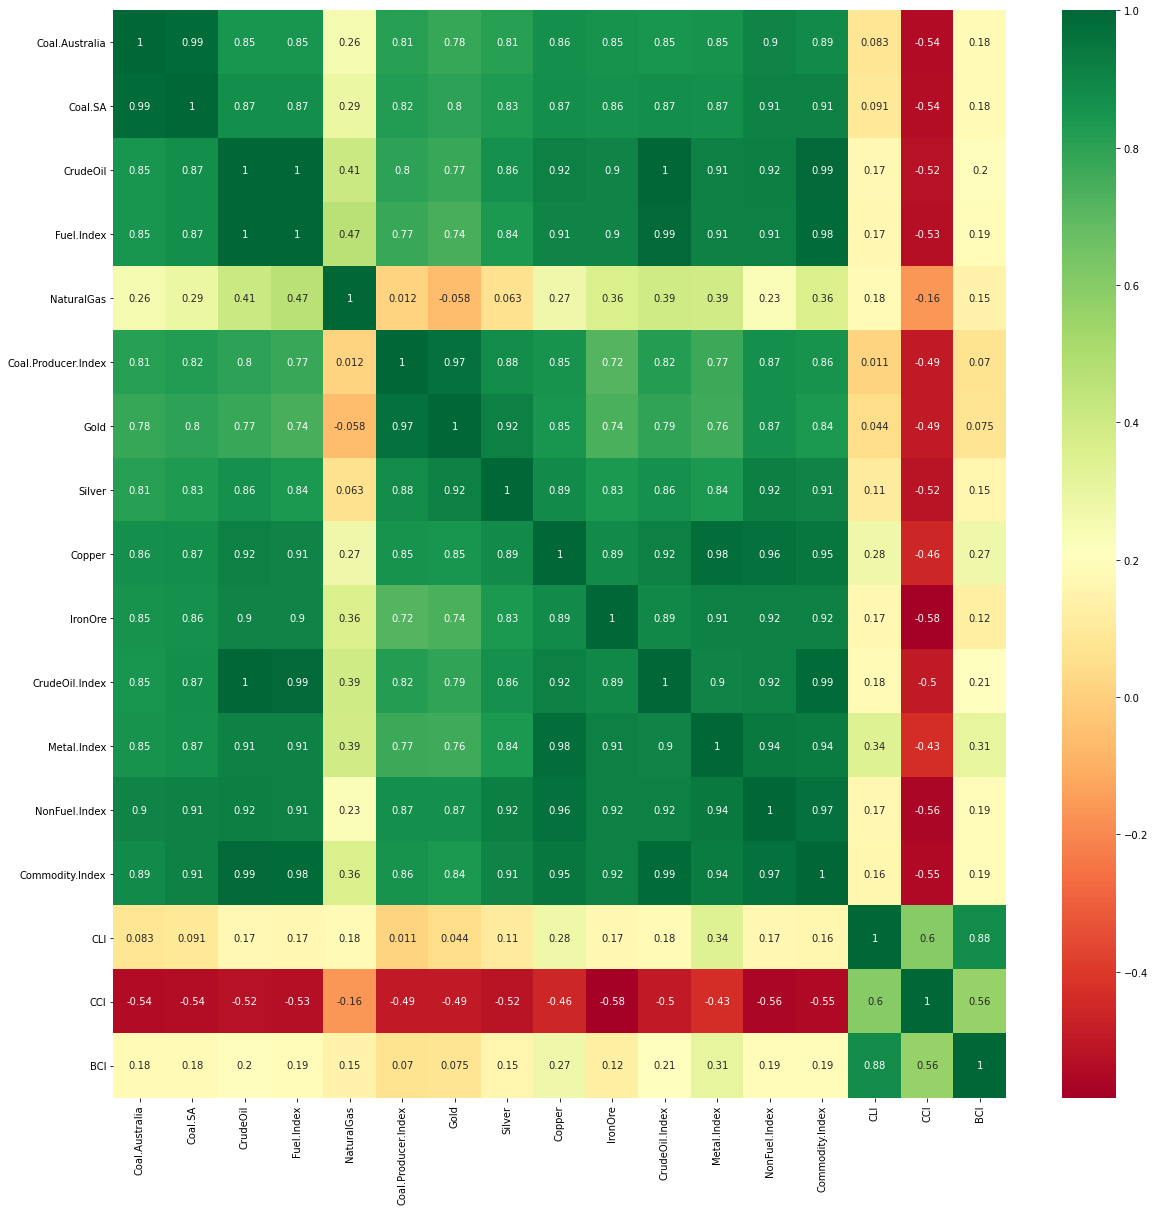

In [35]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

We will look at the features that have higher correlation than 0.5 with our target variable.

In [75]:
#Correlation with output variable
cor_target = abs(corrmat["Coal.SA"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

Coal.Australia         0.987597
Coal.SA                1.000000
CrudeOil               0.871322
Fuel.Index             0.873123
Coal.Producer.Index    0.823938
Gold                   0.801117
Silver                 0.829874
Copper                 0.874786
IronOre                0.862946
CrudeOil.Index         0.870686
Metal.Index            0.865686
NonFuel.Index          0.910450
Commodity.Index        0.907782
CCI                    0.539615
Name: Coal.SA, dtype: float64


Now, we will check the correlation between these variables.

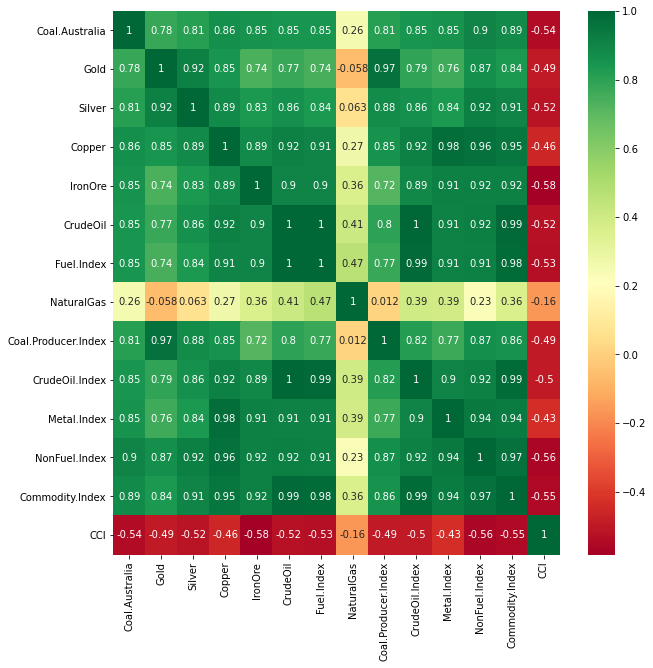

In [77]:
rf_df = df[['Coal.Australia', 'Gold','Silver','Copper','IronOre','CrudeOil','Fuel.Index','NaturalGas','Coal.Producer.Index','CrudeOil.Index','Metal.Index','NonFuel.Index','Commodity.Index','CCI']]
fig, ax = plt.subplots(figsize=(10,10))
h=sns.heatmap(rf_df.corr(),annot=True,cmap="RdYlGn",ax=ax)

## Notes about correlation

From the above correlation matrix, we get the following results
    * Gold and Copper has high correlation
    * Gold and Coal.Producer.Index has high correlation
    * Silver and Gold has high Correlation
    * Silver and NonFuel.Index has high correlation also there is high correlation with Commodity.Index
    * Copper and CrudeOil,Fuel.Index,Metal.Index,NonFuel.Index,Commodity.Index and CrudeOil.Index has    high correlation
    * IronOre and Fuel.Index,CrudeOil,Metal.Index,NonFuel.Index,Commodity.Index has high correlation
    * CrudeOil and Metal.Index,NonFuel.Index,Commodity.Index has high correlation
    * CrudeOil.Index and Fuel.Index,NonFuel.Index,Metal.Index has high correlation
    * Metal.Index has high correlation with Fuel.Index,NonFuel.Index,Commodity.Index
    * NonFuel.Index has high correlation with Fuel.Index,Commodity.Index
    
 We will check these variables correlation with our target variable and then drop the  attribute that has lowest correlation with our target. 

In [79]:
df

,Date,Coal.Australia,Coal.SA,CrudeOil,Fuel.Index,NaturalGas,Coal.Producer.Index,Gold,Silver,Copper,IronOre,CrudeOil.Index,Metal.Index,NonFuel.Index,Commodity.Index,CLI,CCI,BCI
0,1992-01-01,39.50,31.00,17.38,23.71,1.28,93.6,354.45,4.11,2139.23,33.10,40.23,35.59,48.40,50.72,99.20515,99.36520,99.32731
1,1992-01-02,39.50,31.00,17.62,23.83,1.21,93.8,353.91,4.15,2205.97,33.10,41.09,37.12,48.71,50.72,99.22767,99.46713,99.51028
2,1992-01-03,39.50,31.00,17.45,23.79,1.28,93.6,344.34,4.11,2227.33,33.10,41.17,37.41,48.74,50.75,99.25694,99.62660,99.67402
3,1992-01-04,39.50,31.00,18.63,25.24,1.47,94.1,338.62,4.05,2215.33,33.10,44.09,38.00,48.45,51.17,99.26983,99.72688,99.74699
4,1992-01-05,39.50,31.00,19.50,26.33,1.59,94.7,337.24,4.07,2216.52,33.10,45.57,37.99,48.57,52.64,99.23967,99.75301,99.77460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2020-01-03,66.74,67.89,32.20,42.06,1.78,192.4,1591.93,14.88,5182.63,88.99,76.22,68.71,78.18,93.87,100.08840,99.24226,98.41069
339,2020-01-04,58.55,56.58,21.04,29.35,1.73,191.5,1683.17,15.07,5057.97,84.73,50.45,65.55,76.07,84.15,99.24226,98.32549,97.59643
340,2020-01-05,52.49,57.42,30.38,38.81,1.75,194.9,1715.91,16.26,5239.83,93.65,72.25,68.01,76.62,91.37,98.32549,98.04079,97.52828
341,2020-01-06,52.21,56.81,39.46,48.34,1.62,193.6,1732.22,17.71,5754.60,103.30,92.83,73.68,79.78,99.79,98.04079,98.20473,98.16690


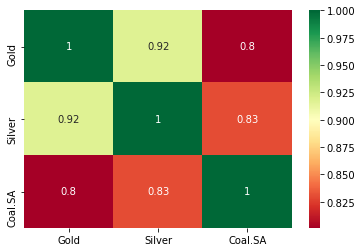

In [84]:
h=sns.heatmap(df[['Gold','Silver','Coal.SA']].corr(),annot=True,cmap="RdYlGn")
#Silver has higher correlation with our target variable. (drop gold)

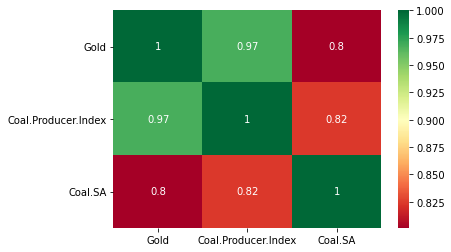

In [97]:
h=sns.heatmap(df[['Gold','Coal.Producer.Index','Coal.SA']].corr(),annot=True,cmap="RdYlGn")
#drop gold

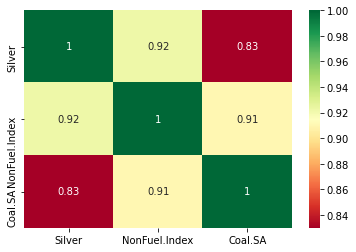

In [85]:
h=sns.heatmap(df[['Silver','NonFuel.Index','Coal.SA']].corr(),annot=True,cmap="RdYlGn")
#Non fuel index has higher correlation. (drop silver)

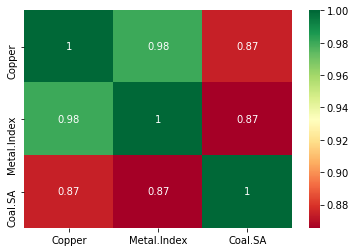

In [88]:
h=sns.heatmap(df[['Copper','Metal.Index','Coal.SA']].corr(),annot=True,cmap="RdYlGn")
#(does not matter)

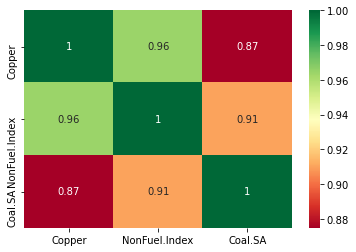

In [89]:
h=sns.heatmap(df[['Copper','NonFuel.Index','Coal.SA']].corr(),annot=True,cmap="RdYlGn") 
#(take nonfuel)

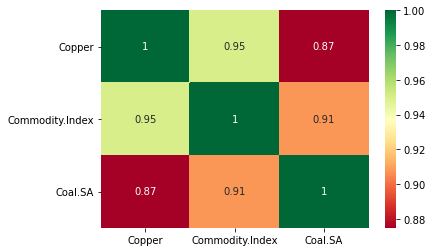

In [90]:
h=sns.heatmap(df[['Copper','Commodity.Index','Coal.SA']].corr(),annot=True,cmap="RdYlGn") 
#(take comoddity)

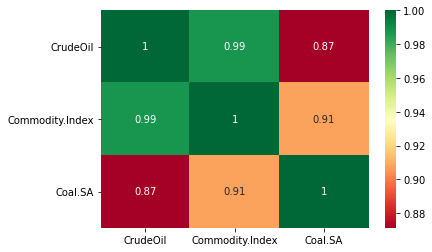

In [91]:
h=sns.heatmap(df[['CrudeOil','Commodity.Index','Coal.SA']].corr(),annot=True,cmap="RdYlGn") 
#(take comoddity)

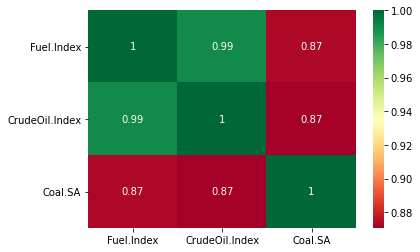

In [93]:
h=sns.heatmap(df[['Fuel.Index','CrudeOil.Index','Coal.SA']].corr(),annot=True,cmap="RdYlGn") 
#(does not matter, take crudeOil)

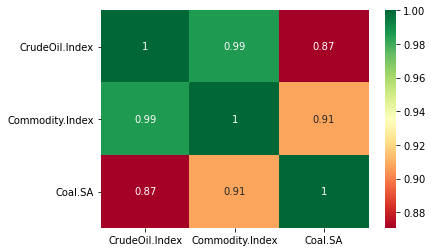

In [95]:
h=sns.heatmap(df[['CrudeOil.Index','Commodity.Index','Coal.SA']].corr(),annot=True,cmap="RdYlGn") 
#(take comoddity)

We will take all the variables has high correlation with our target "Corel.SA" and drop the others.
After this analysis we saw that the attribute "Natural Gas" has high importance.

In [98]:
df=df.drop(['Gold','Silver','Copper','CrudeOil','CLI','BCI'], axis=1)
df.head()

,Date,Coal.Australia,Coal.SA,Fuel.Index,NaturalGas,Coal.Producer.Index,IronOre,CrudeOil.Index,Metal.Index,NonFuel.Index,Commodity.Index,CCI
0,1992-01-01,39.5,31.0,23.71,1.28,93.6,33.1,40.23,35.59,48.40,50.72,99.36520
1,1992-01-02,39.5,31.0,23.83,1.21,93.8,33.1,41.09,37.12,48.71,50.72,99.46713
2,1992-01-03,39.5,31.0,23.79,1.28,93.6,33.1,41.17,37.41,48.74,50.75,99.62660
3,1992-01-04,39.5,31.0,25.24,1.47,94.1,33.1,44.09,38.00,48.45,51.17,99.72688
4,1992-01-05,39.5,31.0,26.33,1.59,94.7,33.1,45.57,37.99,48.57,52.64,99.75301


EDA:
Plotting "trend". Visualize and check seasonality trend of our time series.

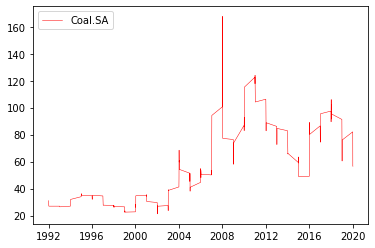

In [99]:
plt.plot(df.Date, df['Coal.SA'], linewidth=0.5, color='red')
plt.legend(["Coal.SA"], loc ="upper left") 
plt.show()

We can see that:
1) Coal series has a trend. It goes up for few years and then goes down for some year and then again goes up. It's not stationary

We can check stationarity using the following methods: (not implemented here as it is clear to know it's stationary)
   1) Dickey-Fuller Test: The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the test statistic is less than the critical value, we can say that time series is stationary.
  
   2) Plotting Rolling Statistics: We have a window lets say window size is 6 and then we find rolling mean and variance to check stationary.
   

In [100]:
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Day'] = pd.DatetimeIndex(df['Date']).day
#df.head()

Let's plot the mean year wise. It reveal that indeed the timeseries is not stationary.

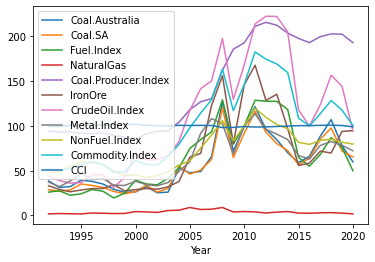

In [101]:
mean_all=df.groupby('Year').mean()
mean_all = mean_all.drop(['Day'], axis=1)
mean_all.plot()

First plot boxplots for each year to examine outliers:

[Text(0, 0, '1992'),
 Text(0, 0, '1993'),
 Text(0, 0, '1994'),
 Text(0, 0, '1995'),
 Text(0, 0, '1996'),
 Text(0, 0, '1997'),
 Text(0, 0, '1998'),
 Text(0, 0, '1999'),
 Text(0, 0, '2000'),
 Text(0, 0, '2001'),
 Text(0, 0, '2002'),
 Text(0, 0, '2003'),
 Text(0, 0, '2004'),
 Text(0, 0, '2005'),
 Text(0, 0, '2006'),
 Text(0, 0, '2007'),
 Text(0, 0, '2008'),
 Text(0, 0, '2009'),
 Text(0, 0, '2010'),
 Text(0, 0, '2011'),
 Text(0, 0, '2012'),
 Text(0, 0, '2013'),
 Text(0, 0, '2014'),
 Text(0, 0, '2015'),
 Text(0, 0, '2016'),
 Text(0, 0, '2017'),
 Text(0, 0, '2018'),
 Text(0, 0, '2019'),
 Text(0, 0, '2020')]

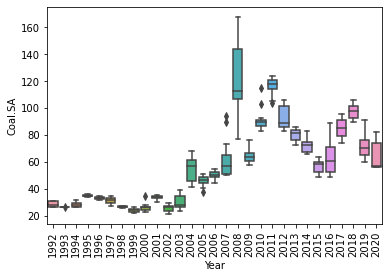

In [102]:
ax = sns.boxplot(data=df, x='Year', y='Coal.SA')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

Now, let's plot boxplots for each day to check any outliers. These outliers can be removed for better forecasting results!

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12')]

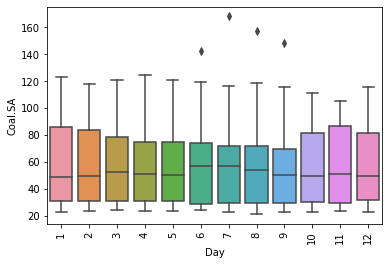

In [103]:
ax = sns.boxplot(data=df, x='Day', y='Coal.SA')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [104]:
dfnew = df.drop(['Year','Day'], axis=1)
dfnew = dfnew.set_index('Date')
#dfnew.head()

Using the differencing method to make the time series stationary

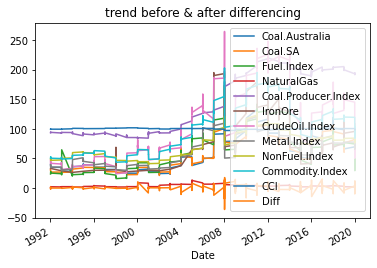

In [105]:
import numpy as np
#dfnew['Diff'] = dfnew- dfnew.shift(1)
dfnew['Diff'] = np.append([np.nan]*2,np.diff(dfnew['Coal.SA'], n=2))
dfnew.dropna().plot(title="trend before & after differencing")
#dfnew has two columns before and after differencing

We can see from graph that it's stationary now

In [106]:
ts = dfnew.drop(['Diff'], axis =1)
#ts

In [107]:
dfnew.reset_index(level=0, inplace=True)
dfnew['Year'] = pd.DatetimeIndex(dfnew['Date']).year
dfnew.groupby('Year').mean()
#just to have a look at the means year-wise
#And plotting these values below

,Coal.Australia,Coal.SA,Fuel.Index,NaturalGas,Coal.Producer.Index,IronOre,CrudeOil.Index,Metal.Index,NonFuel.Index,Commodity.Index,CCI,Diff
Year,,,,,,,,,,,,
1992,38.562500,28.833333,26.055833,1.771667,93.991667,33.100000,43.763333,37.320000,48.112500,51.686667,99.485114,0.000000
1993,31.333333,26.958333,27.544447,2.120833,93.333333,29.090000,38.940833,32.145000,48.590000,50.390000,99.324812,-0.041667
1994,32.300000,28.562500,22.512500,1.920000,93.175000,26.470000,36.062500,38.565833,55.227500,52.752500,100.555102,0.166667
1995,39.371667,35.229167,24.139167,1.722500,91.566667,28.380000,36.765833,46.961667,60.148333,56.496667,100.573692,-0.213333
1996,38.074167,33.517500,28.941667,2.734167,91.366667,30.000000,45.500000,40.055833,58.916667,60.216667,100.451742,0.163333
1997,35.099167,31.349167,27.097500,2.481667,92.233333,30.150000,45.375000,41.290000,57.397500,56.870000,100.978042,-0.070000
1998,29.230833,26.839167,19.540833,2.086667,89.483333,34.158638,31.278333,33.763333,49.303333,48.038333,101.156100,-0.005000
1999,25.891667,24.273333,24.839167,2.266667,87.258333,27.590000,42.652500,33.525833,44.610833,48.660833,101.538108,-0.076667
2000,26.250000,26.570000,39.395833,4.308333,84.758333,28.790000,69.500000,38.249167,45.055833,61.092500,101.765917,0.787500


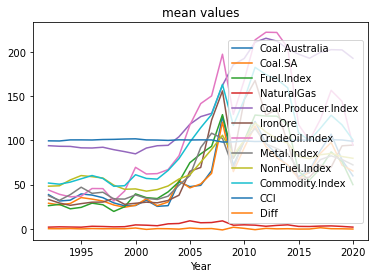

In [108]:
dfnew.reset_index(level=0, inplace=True)
dfnew['Year'] = pd.DatetimeIndex(dfnew['Date']).year
dfnew = dfnew.drop("index", axis=1)
meandf = dfnew.groupby('Year').mean()
meandf.plot(title="mean values")

In [109]:
ts_diff = dfnew.drop(['Coal.SA','Year'], axis=1)
ts_diff = ts_diff.set_index('Date')
ts_diff.dropna(inplace=True)
#ts_diff

# ARIMA

(p,d,q) is parameters of ARIMA model.

In order to choose p,d,q parameters we will use two different plots.

1) Autocorrelation Function (ACF): Measurement of the correlation between time series and lagged version of time series.

2) Partial Autocorrelation Function (PACF): This measures the correlation between the time series and lagged version of time series but after eliminating the variations already explained by the intervening comparisons.



In [110]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Users\Didem Durukan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


ValueError: x is required to have ndim 1 but has ndim 2

Two dotted lines are the confidence interevals. We use these lines to determine the ‘p’ and ‘q’ values

    Choosing p: The lag value where the PACF chart crosses the upper confidence interval for the first time. p=1.
    Choosing q: The lag value where the ACF chart crosses the upper confidence interval for the first time. q=1.


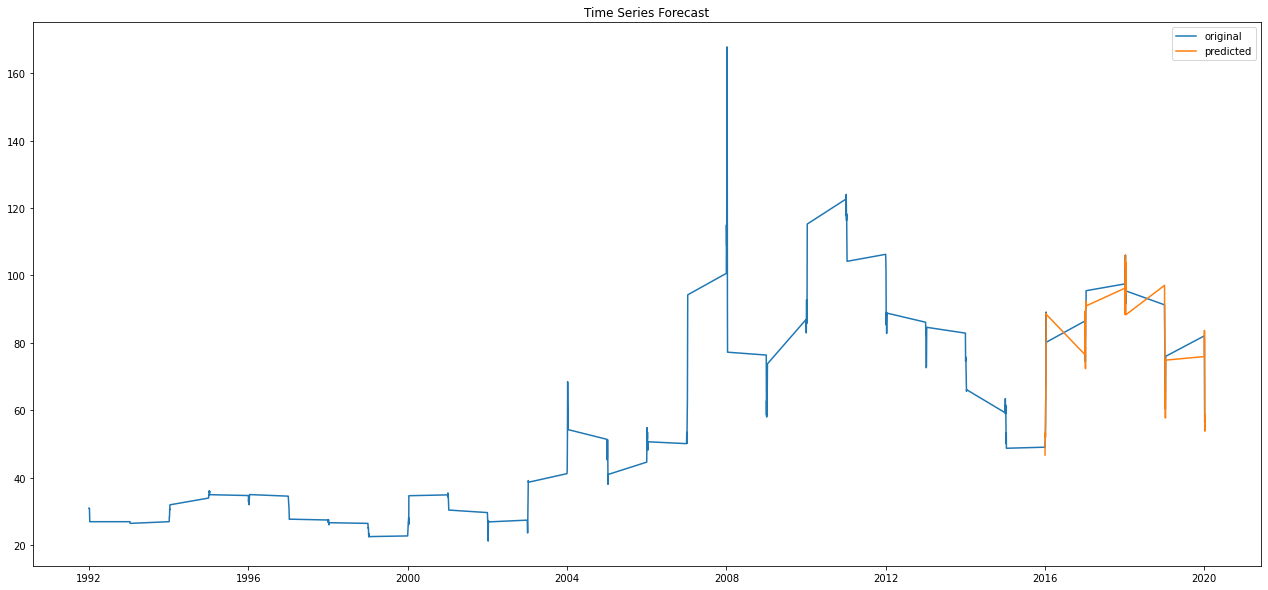

In [19]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
import warnings
warnings.filterwarnings("ignore")

# fit model
model = ARIMA(ts, order=(1,0,1))
model_fit = model.fit(disp=0)
#print(model_fit.summary())

# predict from and to these dates
start_index = datetime(2016, 1, 1)
end_index = datetime(2020, 1, 7)
forecast = model_fit.predict(start=start_index, end=end_index)

# visualization
plt.figure(figsize=(22,10))
plt.plot(df.Date,df['Coal.SA'],label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast")
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, r2_score
actual=ts[-55:]
actual =actual.values
error = mean_squared_error(actual, forecast, squared = False)
#let's calculate the metric R^2 to compare all models
#import sklearn.metrics as sm
print("RMSE =",error)
print("R^2 score =", round(r2_score(actual, forecast), 2))
# if R^2 is nearly 1, it's the best case.

RMSE = 5.113200997650385
R^2 score = 0.9
